# Глава 4

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import time

from tqdm import tqdm
from collections import defaultdict

from typing import List, Set

In [6]:
BitWord = List[int]

In [7]:
# generate all sequences of length l
def generate(l):
    res = []
    
    for i in range(0, 2**l):
        b = bin(i)[2:]
        b = '0' * (l - len(b)) + b
        b = np.array(list(map(lambda x: int(x), b)))
        res.append(b)
        
    return np.array(res)

# Задание 2

In [8]:
n = 10
k = 6
r = 4
H = np.array([
    [0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
])

G = np.array([
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0], 
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
])

# Минимальная спэновая форма
G = np.array([
        [1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
])


p0 = 1e-5

all_words = generate(n)

code_words = []
for word in all_words:
    if np.all(np.dot(word, H.T) % 2 == 0):
        code_words.append(word)

In [9]:
np.dot(G, H.T) % 2

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [10]:
def L(y):
    if y == 1:
        return math.log2((1 - p0) / p0)
    else:
        return math.log2(p0 / (1 - p0))
    
L = np.vectorize(L)

In [11]:
# Множитель 4 * sqrt(E) / N0 не влияет, поэтому просто возвращаем y
def L_noisy(y):
    return y
    
L_noisy = np.vectorize(L_noisy)

In [12]:
def mp_decode(L, y: BitWord) -> BitWord:
    y = L(y)
    mx = np.sum(-L(np.ones(n)))
    c = np.zeros(n)
    
    for cur in code_words:
        if np.dot(2 * cur - 1, y) > mx:
            mx = np.dot(2 * cur - 1, y)
            c = cur
            
    return c

In [13]:
def mav_decode(L, y: BitWord) -> BitWord:
    mx = np.sum(-L(np.ones(n)))
    c = np.zeros(n)
    
    for cur in code_words:
        if np.dot(2 * y - 1, L(cur)) > mx:
            mx = np.dot(2 * y - 1, L(cur))
            c = cur
            
    return c

In [14]:
print(mp_decode(L, np.array([1,1,1,1,1,0,0,0,0,0])))
print(mp_decode(L_noisy, np.array([1,1,1,1,1,0,0,0,0,0])))

print(mav_decode(L, np.array([1,1,1,1,1,0,0,0,0,0])))
print(mav_decode(L_noisy, np.array([1,1,1,1,1,0,0,0,0,0])))

[1 1 1 1 1 0 0 1 0 0]
[1 1 1 1 1 0 0 1 0 0]
[1 1 1 1 1 0 0 1 0 0]
[1 1 1 1 1 0 0 1 0 0]


In [15]:
def get_prob_of_error(decode_algo, p0):
    prob_of_error = 0
    for c in code_words:
        for e in all_words:
            current_prob = (p0 ** np.sum(e)) * ((1 - p0) ** (n - np.sum(e)))
            if (prob_of_error / current_prob >= (1 / p0)): # will not affect error
                continue
                
            if not np.all(np.equal(decode_algo((c + e) % 2), c)):
                prob_of_error += current_prob
            
    return prob_of_error / len(code_words)

In [16]:
def get_prob_of_error(decode_algo, p0):
    prob_of_error = 0
    for c in code_words:
        for e in all_words:
            current_prob = (p0 ** np.sum(e)) * ((1 - p0) ** (n - np.sum(e)))
            if (prob_of_error / current_prob >= (1 / p0)): # will not affect error
                continue
                
            if not np.all(np.equal(decode_algo((c + e) % 2), c)):
                prob_of_error += current_prob
            
    return prob_of_error / len(code_words)

In [17]:
no_decode_l = lambda y : y

mp_decode_l = lambda y : mp_decode(L, y) 
mp_decode_l_noisy = lambda y : mp_decode(L_noisy, y)

mav_decode_l = lambda y : mav_decode(L, y)
mav_decode_l_noisy = lambda y : mav_decode(L_noisy, y)

In [18]:
get_prob_of_error(mp_decode_l, 1e-5)

3.9996800111998311e-09

In [19]:
p0s = 1 / np.power(10, np.arange(2,6))

def get_errors(decode):
    errors = []
    for p in tqdm(p0s):
        errors.append(get_prob_of_error(decode, p))
    return errors 

# Зависимость log вероятности ошибки от p0 для различных методов (ДСК)

100%|██████████| 4/4 [01:08<00:00, 16.71s/it]


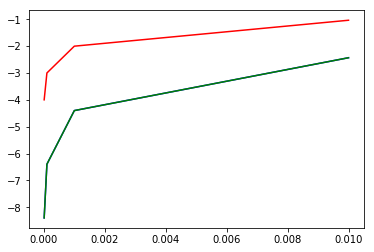

In [233]:
plt.plot(p0s, np.log10(get_errors(no_decode_l)), color='r')
plt.plot(p0s, np.log10(get_errors(mp_decode_l)), color='b')
plt.plot(p0s, np.log10(get_errors(mav_decode_l)), color='g')
plt.show()

# Зависимость log вероятности ошибки от p0 для различных методов (АБГШ)

100%|██████████| 4/4 [01:13<00:00, 17.73s/it]


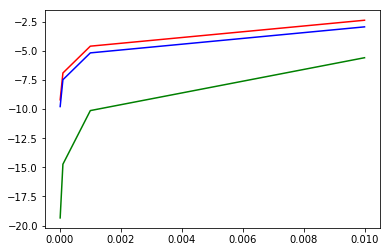

In [234]:
plt.plot(p0s, np.log(get_errors(no_decode_l)), color='r')
plt.plot(p0s, np.log(get_errors(mp_decode_l_noisy)), color='b')
plt.plot(p0s, np.log(get_errors(mav_decode_l_noisy)), color='g')
plt.show()

# Энергетический выигрыш кодирования

Рассмотрим для примера выигрыш кодирования при декодировании по максимуму правдоподбия и $p_0 = 10^{-5}$:

In [240]:
get_prob_of_error(no_decode_l, 1e-5)

9.9991000359993067e-05

Тоесть при ошибке на бит $p_0 = 10^{-5}$ вероятность ошибки декодера составит $10^{-4}$. Посчитаем, какая $p_0$ нужна, чтобы добится такой ошибки с помощью алгоритма декодирования по максимуму правдоподбия:

In [241]:
for p in range(1, 4):
    print(get_prob_of_error(mp_decode_l, 10**(-p)))

0.000672605015625
0.000145620647089
1.55159370627e-05


Видим, что достаточно $p_0 \approx 10^{-2}$

Тогда выигрыш кодирования составит:

Без кодирования:
$p = 1 * 10^{-5} \frac{E_b}{N_0} \approx 9.5дБ$

С кодированием:
$p = 1 * 10^{-2} \frac{E_b}{N_0} = 4.3дБ$

Выигрыш кодирования = $9.5 - \frac{4.3}{R} = 9.5 - 7.2 = 2.3дБ$

# Задание 3

In [28]:
n = 5

G = np.array([
    [1, 1, 0, 1, 0],
    [1, 0, 1, 1, 1]
]) 

# Преобразовали в систематический вид
# G = np.array([
#     [1, 0, 1, 1, 1],
#     [0, 1, 1, 0, 1]
# ])

H = np.array([
    [1, 1, 1, 0, 0],
    [1, 0, 0, 1, 0],
    [1, 1, 0, 0, 1],
])

p0 = 0.1
y = np.array([0, 1, 1, 1, 1])

all_words = generate(n)

code_words = []
for word in all_words:
    if np.all(np.dot(word, H.T) % 2 == 0):
        code_words.append(word)

In [29]:
np.dot(G, H.T) % 2

array([[0, 0, 0],
       [0, 0, 0]])

Апостериорая вероятность кодового слова записывается в виде: $p(c_m\ | \ y)$. При $p_0 = 0.1$ получаем, что:

$p(0|y_i = 1) = 0.1 \, \, p(1|y_i = 1) = 0.9$ 


$p(0|y_i = 0) = 0.9 \, \, p(1|y_i = 0) = 0.1$

Апостериорная вероятность для кодового слова запишется в виде: $\prod_{i=1}^{n}\ p(c_{mi}|y_i)$. Посчитаем ее:

In [27]:
print('МП декодирование:', mp_decode(L, y))
print('МАВ декодирование:', mav_decode(L, y))

МП декодирование: [0 1 1 0 1]
МАВ декодирование: [0 1 1 0 1]


# Задание 4

## Построение по проверочной матрице (полная решетка в отдельном файле)

In [33]:
nodes = {() : [0,0,0,0]}

def is_code_word_prefix(code_words, check_word):
    size = len(check_word)
    for word in code_words:
        if (np.all(np.array(word[:size]) == np.array(check_word))):
            return True
    return False

def process_word(word_p, word_c, next_line):
    pref = np.dot(word_c, H[:, :i+1].T) % 2
    if is_code_word_prefix(code_words, word_c):
        next_line.append(word_c)
        if not (tuple(pref) in profile[len(word_c)]):
            profile[len(word_c)].add(tuple(pref))
        nodes[tuple(word_c)] = pref
        print('Node {} -> Node {}. Current sequence: {}'.format(nodes[tuple(word_p)], pref, word_c))

prev_line = [[]]
profile = []
for i in range(0, n + 1):
    profile.append(set())

for i in range(0, n):
    print('Level ', i)
    next_line = []
    for word in prev_line:
        process_word(word, [*word, 0], next_line)
        process_word(word, [*word, 1], next_line)
    prev_line = next_line

num_profile = []
for p in profile:
    num_profile.append(len(p))
num_profile[0] = 1

Level  0
Node [0, 0, 0, 0] -> Node [0 0 0 0]. Current sequence: [0]
Node [0, 0, 0, 0] -> Node [0 1 1 1]. Current sequence: [1]
Level  1
Node [0 0 0 0] -> Node [0 0 0 0]. Current sequence: [0, 0]
Node [0 0 0 0] -> Node [0 0 1 0]. Current sequence: [0, 1]
Node [0 1 1 1] -> Node [0 1 1 1]. Current sequence: [1, 0]
Node [0 1 1 1] -> Node [0 1 0 1]. Current sequence: [1, 1]
Level  2
Node [0 0 0 0] -> Node [0 0 0 0]. Current sequence: [0, 0, 0]
Node [0 0 0 0] -> Node [0 0 1 1]. Current sequence: [0, 0, 1]
Node [0 0 1 0] -> Node [0 0 1 0]. Current sequence: [0, 1, 0]
Node [0 0 1 0] -> Node [0 0 0 1]. Current sequence: [0, 1, 1]
Node [0 1 1 1] -> Node [0 1 1 1]. Current sequence: [1, 0, 0]
Node [0 1 1 1] -> Node [0 1 0 0]. Current sequence: [1, 0, 1]
Node [0 1 0 1] -> Node [0 1 0 1]. Current sequence: [1, 1, 0]
Node [0 1 0 1] -> Node [0 1 1 0]. Current sequence: [1, 1, 1]
Level  3
Node [0 0 0 0] -> Node [0 0 0 0]. Current sequence: [0, 0, 0, 0]
Node [0 0 0 0] -> Node [1 0 0 1]. Current sequenc

In [34]:
print('Профиль:', num_profile)

Профиль: [1, 2, 4, 8, 16, 16, 8, 8, 4, 2, 1]


## Построение по порождающей матрице

Профиль: (1 2 4 8 16 16 8 8 4 2 1)